原地址：https://github.com/llSourcell/How-to-Use-Tensorflow-for-Time-Series-Live-/blob/master/demo_full_notes.ipynb

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 
from __future__ import print_function, division
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
Image(url= "https://cdn-images-1.medium.com/max/1600/1*UkI9za9zTR-HL8uM15Wmzw.png")

In [40]:
#hyperparams

num_epochs = 5
total_series_length = 50000
truncated_backprop_length = 15
state_size = 4
num_classes = 2
echo_step = 3
batch_size = 5
num_batches = total_series_length//batch_size//truncated_backprop_length

In [19]:
# choice(a, size=None, replace=True, p=None)

# Generates a random sample from a given 1-D array
np.random.choice(4,20,p=[0.1,0.25,0.25,0.4])

array([1, 1, 0, 1, 2, 2, 3, 1, 3, 3, 2, 1, 1, 1, 1, 3, 2, 1, 3, 3])

In [20]:
# 第一步，collect data
# 输入是一个二元的vector data，而输出则是一个 echo_state，将数据左移echo_step产生

def generateData():
    #0,1, 50K samples, 50% chance each chosen
    x = np.array(np.random.choice(2, total_series_length, p=[0.5, 0.5]))
    #shift 3 steps to the left
    y = np.roll(x, echo_step)
    #padd beginning 3 values with 0
    y[0:echo_step] = 0
    #Gives a new shape to an array without changing its data.
    #The reshaping takes the whole dataset and puts it into a matrix, 
    #that later will be sliced up into these mini-batches.
    x = x.reshape((batch_size, -1))  # The first index changing slowest, subseries as rows
    y = y.reshape((batch_size, -1))

    return (x, y)

data = generateData()

# print(data)

In [21]:
list(data)[0].shape # x （5，10000）

(5, 10000)

In [22]:
# 第二步构建模型
#datatype, shape (5, 15) 2D array or matrix, batch size shape for later
batchX_placeholder = tf.placeholder(tf.float32, [batch_size, truncated_backprop_length])
batchY_placeholder = tf.placeholder(tf.int32, [batch_size, truncated_backprop_length])

#and one for the RNN state, 5,4 
init_state = tf.placeholder(tf.float32, [batch_size, state_size])

In [23]:
np.random.rand(state_size+1, state_size) # (5, 4)
# np.shape(np.random.rand(state_size+1, state_size))

array([[ 0.00563077,  0.0242895 ,  0.10234547,  0.53831769],
       [ 0.54123669,  0.19812725,  0.72408549,  0.47644339],
       [ 0.11091712,  0.51419713,  0.12666874,  0.83239606],
       [ 0.09600556,  0.20569164,  0.34628382,  0.69350262],
       [ 0.1218765 ,  0.34860686,  0.66102863,  0.88259843]])

In [24]:
#3 layer recurrent net, one hidden state

#randomly initialize weights
# 此处为什么W是 state_size+1 呢？因为输入是 5*1 加上状态是 5 * 4，组合为输入就是 [5, 1 + 4]，因此 W 是 1 + state_size
W = tf.Variable(np.random.rand(state_size+1, state_size), dtype=tf.float32) 
#anchor, improves convergance, matrix of 0s 
b = tf.Variable(np.zeros((1,state_size)), dtype=tf.float32)

W2 = tf.Variable(np.random.rand(state_size, num_classes),dtype=tf.float32)
b2 = tf.Variable(np.zeros((1,num_classes)), dtype=tf.float32)

我们看一个例子：总共36个数，batch_size=3，然后truncated_backprop_length=3，每次处理完 truncated_backprop_length，向后移动

In [25]:
Image(url= "https://cdn-images-1.medium.com/max/1600/1*n45uYnAfTDrBvG87J-poCA.jpeg")

In [27]:
# 我们将batch data转换到相邻的 time-steps
# batchX_placeholder (5, 15) => inputs_series，将其组装为一列一列输出
inputs_series = tf.unstack(batchX_placeholder, axis=1)
labels_series = tf.unstack(batchY_placeholder, axis=1)

In [28]:
# tf.unstack() 我们可以方便的进行将数据转换为列后输出
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    x = tf.placeholder(tf.float32, [4, 3])
    data = tf.unstack(x,axis=1)
    data_list = sess.run(data,feed_dict={
        x:[[1,2,3],[2,4,6],[3,6,9],[4,8,12]]
    })
    print(data_list) 

[array([ 1.,  2.,  3.,  4.], dtype=float32), array([ 2.,  4.,  6.,  8.], dtype=float32), array([  3.,   6.,   9.,  12.], dtype=float32)]


In [31]:
Image(url= "https://cdn-images-1.medium.com/max/1600/1*f2iL4zOkBUBGOpVE7kyajg.png")
#Schematic of the current batch split into columns, the order index is shown on each data-point 
#and arrows show adjacent time-steps.
# 上面 unstack 作用就如下图所示

In [29]:
# 我们可以看到 axis=1 的时候就是行数不变，将后面一个并入
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    t1 = [[1],
       [2],
       [3],
       [4],
       [5]]
    t2 = [[1,2,3,4],[2,4,6,8],[3,2,3,4],[4,2,3,4],[5,2,3,4]]
    print(sess.run(tf.concat([t1,t2],1)))

[[1 1 2 3 4]
 [2 2 4 6 8]
 [3 3 2 3 4]
 [4 4 2 3 4]
 [5 5 2 3 4]]


In [32]:
#Forward pass
#state placeholder
current_state = init_state
#series of states through time
states_series = []


#for each set of inputs
#forward pass through the network to get new state value
#store all states in memory
for current_input in inputs_series:
    #format input
    current_input = tf.reshape(current_input, [batch_size, 1])
    #mix both state and input data 
    # 变为了 [batch_size,1+state_size] [5,5]
    input_and_state_concatenated = tf.concat([current_input, current_state],1)  # Increasing number of columns
    #perform matrix multiplication between weights and input, add bias
    #squash with a nonlinearity, for probabiolity value
    next_state = tf.tanh(tf.matmul(input_and_state_concatenated, W) + b)  # Broadcasted addition
    #store the state in memory
    states_series.append(next_state)
    #set current state to next one
    current_state = next_state

In [33]:
Image(url= "https://cdn-images-1.medium.com/max/1600/1*fdwNNJ5UOE3Sx0R_Cyfmyg.png")

此处 truncated_backprop_length 的作用是：RNN中不断将网络重复，但是如果我们一直将其保留在内存中，成本会非常大，因此我们需要适时的进行截断， truncated_backprop_length 就是保留在内存中的最大深度

In [34]:
#calculate loss
#second part of forward pass
#logits short for logistic transform
logits_series = [tf.matmul(state, W2) + b2 for state in states_series] #Broadcasted addition
#apply softmax nonlinearity for output probability
predictions_series = [tf.nn.softmax(logits) for logits in logits_series]

In [ ]:
# tf.nn.sparse_softmax_cross_entropy_with_logits

In [36]:
# 计算损失函数
#measure loss, calculate softmax again on logits, then compute cross entropy
#measures the difference between two probability distributions
#this will return A Tensor of the same shape as labels and of the same type as logits 
#with the softmax cross entropy loss.
losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels) for logits, labels in zip(logits_series,labels_series)]
#computes average, one value
total_loss = tf.reduce_mean(losses)

In [37]:
# 使用的优化方法不是 SGD 而是 adagrad 
# SGD 的缺点是：对于学习rate比较敏感 
# 每个 feature 都应该有一个不同的 learning rate
# 有大梯度的应该有小的learning rate
# 小梯度的则是大的learning rate
# http://seed.ucsd.edu/mediawiki/images/6/6a/Adagrad.pdf

#use adagrad to minimize with .3 learning rate
#minimize it with adagrad, not SGD
#One downside of SGD is that it is sensitive to
#the learning rate hyper-parameter. When the data are sparse and features have
#different frequencies, a single learning rate for every weight update can have
#exponential regret.
#Some features can be extremely useful and informative to an optimization problem but 
#they may not show up in most of the training instances or data. If, when they do show up, 
#they are weighted equally in terms of learning rate as a feature that has shown up hundreds 
#of times we are practically saying that the influence of such features means nothing in the 
#overall optimization. it's impact per step in the stochastic gradient descent will be so small 
#that it can practically be discounted). To counter this, AdaGrad makes it such that features 
#that are more sparse in the data have a higher learning rate which translates into a larger 
#update for that feature
#sparse features can be very useful.
#Each feature has a different learning rate which is adaptable. 
#gives voice to the little guy who matters a lot
#weights that receive high gradients will have their effective learning rate reduced, 
#while weights that receive small or infrequent updates will have their effective learning rate increased. 
#great paper http://seed.ucsd.edu/mediawiki/images/6/6a/Adagrad.pdf
train_step = tf.train.AdagradOptimizer(0.3).minimize(total_loss)

In [46]:
pred = [[1,1,0,1,0],[1,1,0,1,0],[1,1,0,1,0]]
np.array(pred).shape

(3, 5)

In [38]:
# 可视化函数
# visualizer
def plot(loss_list, predictions_series, batchX, batchY):
    # 2 行 3 列
    plt.subplot(2, 3, 1)
    plt.cla()
    plt.plot(loss_list)

    for batch_series_idx in range(5):
        one_hot_output_series = np.array(predictions_series)[:, batch_series_idx, :]
        single_output_series = np.array([(1 if out[0] < 0.5 else 0) for out in one_hot_output_series])

        plt.subplot(2, 3, batch_series_idx + 2)
        plt.cla()
        plt.axis([0, truncated_backprop_length, 0, 2]) # [xmin, xmax, ymin, ymax]
        left_offset = range(truncated_backprop_length)
        plt.bar(left_offset, batchX[batch_series_idx, :], width=1, color="blue") # plt.bar(left, height, width=0.8, bottom=None
        plt.bar(left_offset, batchY[batch_series_idx, :] * 0.5, width=1, color="red")
        plt.bar(left_offset, single_output_series * 0.3, width=1, color="green")

    plt.draw()
    plt.pause(0.0001)

蓝色代表输入
Blue bars denote a training input signal (binary one)
红色代表真实输出
red bars show echos in the training output 
绿色是预测的值
green bars are the echos the net is generating. 

Instructions for updating:
Use `tf.global_variables_initializer` instead.


New data, epoch 0
Step 0 Loss 0.688147
Step 100 Loss 0.429072
Step 200 Loss 0.0273838
Step 300 Loss 0.0074923
Step 400 Loss 0.00684299
Step 500 Loss 0.00336111
Step 600 Loss 0.00264705
New data, epoch 1
Step 0 Loss 0.200985
Step 100 Loss 0.00177809
Step 200 Loss 0.00198204
Step 300 Loss 0.00151109
Step 400 Loss 0.00161748
Step 500 Loss 0.00124855
Step 600 Loss 0.00113709
New data, epoch 2
Step 0 Loss 0.203546
Step 100 Loss 0.00097241
Step 200 Loss 0.00107177
Step 300 Loss 0.000753635
Step 400 Loss 0.000810073
Step 500 Loss 0.000749434
Step 600 Loss 0.000740377
New data, epoch 3
Step 0 Loss 0.220854
Step 100 Loss 0.000735126
Step 200 Loss 0.00060384
Step 300 Loss 0.000532169
Step 400 Loss 0.000571297
Step 500 Loss 0.000684456
Step 600 Loss 0.00045192
New data, epoch 4
Step 0 Loss 0.254147
Step 100 Loss 0.000534385
Step 200 Loss 0.000542578
Step 300 Loss 0.000474023
Step 400 Loss 0.000409939
Step 500 Loss 0.000416673
Step 600 Loss 0.000403649


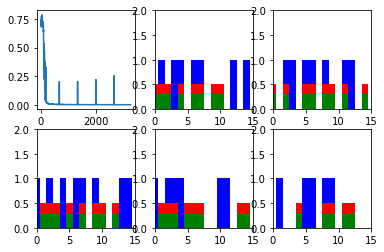

In [51]:
#Step 3 Training the network
with tf.Session() as sess:
    #we stupidly have to do this everytime, it should just know
    #that we initialized these vars. v2 guys, v2..
    sess.run(tf.initialize_all_variables())
    #interactive mode
    plt.ion()
    #initialize the figure
    plt.figure()
    #show the graph
    plt.show()
    #to show the loss decrease
    loss_list = []

    for epoch_idx in range(num_epochs):
        #generate data at eveery epoch, batches run in epochs
        x,y = generateData()
        #initialize an empty hidden state
        _current_state = np.zeros((batch_size, state_size))

        print("New data, epoch", epoch_idx)
        #each batch
        for batch_idx in range(num_batches):
            #starting and ending point per batch
            #since weights reoccuer at every layer through time
            #These layers will not be unrolled to the beginning of time, 
            #that would be too computationally expensive, and are therefore truncated 
            #at a limited number of time-steps
            start_idx = batch_idx * truncated_backprop_length
            end_idx = start_idx + truncated_backprop_length

            batchX = x[:,start_idx:end_idx]
            batchY = y[:,start_idx:end_idx]
            
            #run the computation graph, give it the values
            #we calculated earlier
            # 误差，梯度，当前输出状态，预测
            _total_loss, _train_step, _current_state, _predictions_series = sess.run(
                [total_loss, train_step, current_state, predictions_series],
                feed_dict={
                    batchX_placeholder:batchX,
                    batchY_placeholder:batchY,
                    init_state:_current_state
                })

            loss_list.append(_total_loss)

            if batch_idx%100 == 0:
                print("Step",batch_idx, "Loss", _total_loss)
#                 (15, 5, 2) (5, 15) (5, 15)
#                 print(loss_list,np.shape(_predictions_series),np.shape(batchX),np.shape(batchY))
                plot(loss_list, _predictions_series, batchX, batchY)

plt.ioff()
plt.show()